In [28]:
import subprocess
import sys

# Install required packages
packages = ['mlxtend', 'networkx']
for pkg in packages:
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

print("All packages installed successfully!")

All packages installed successfully!


# Lab 12: Market Basket Analysis & Association Patterns
**Exploring item relationships through rule mining**

# GROUP MEMBERS:
#                M. Haadhee Sheeraz Mian- 478359 


## Part 1: Getting Started with Frequent Patterns
Let's understand how association rules work by starting with a small, manageable example and building our intuition.

In [29]:
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd
# Sample dataset: Movies and attributes
data = {'Comedy': [1, 0, 1, 0],
'Horror': [0, 1, 0, 1],
'Actor_A': [1, 1, 0, 0],
'Director_B': [1, 0, 1, 0]}
df = pd.DataFrame(data)
# Generate frequent itemsets
frequent_itemsets = apriori(df, min_support=0.5, use_colnames=True)
# Generate rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
print(rules)

    antecedents   consequents  antecedent support  consequent support  \
0      (Comedy)  (Director_B)                 0.5                 0.5   
1  (Director_B)      (Comedy)                 0.5                 0.5   

   support  confidence  lift  representativity  leverage  conviction  \
0      0.5         1.0   2.0               1.0      0.25         inf   
1      0.5         1.0   2.0               1.0      0.25         inf   

   zhangs_metric  jaccard  certainty  kulczynski  
0            1.0      1.0        1.0         1.0  
1            1.0      1.0        1.0         1.0  


### Integration with Clustering Techniques
One interesting approach is to combine frequent pattern mining with clustering algorithms. After extracting rules and computing their metrics (support, confidence, lift), we can represent each rule as a feature vector and apply K-Means or hierarchical clustering to partition them into groups. This enables us to:
- Consolidate massive rule sets into interpretable clusters
- Identify families of similar patterns across the dataset
- Distinguish between strong, moderate, and weak associations systematically

This hybrid approach is especially useful for large-scale retail or web analytics datasets where thousands of rules emerge.

### Challenges in Noisy & High-Dimensional Domains
Association rule mining encounters fundamental limitations when scaled to complex real-world scenarios:

**Rule Explosion:** The number of candidate itemsets grows exponentially with dimensionality, leading to redundant or spurious rules that obscure meaningful patterns.

**Noise Sensitivity:** Random fluctuations and measurement errors get amplified, causing false positive associations that appear statistical but lack real-world validity.

**Computational Cost:** Processing high-dimensional binary matrices requires substantial memory and CPU time; brute-force Apriori becomes impractical beyond ~1000 features.

**Binary Encoding Overhead:** Converting continuous or categorical features into binary indicators multiplies the feature space, exacerbating both noise and complexity.

**Correlation vs. Causation:** The method fundamentally discovers co-occurrence patterns, not causal relationships. Post-mining validation against domain expertise is essential to filter nonsensical rules.

In [30]:
# Basic groceries example: 4 transactions, 4 items
data = {
    'Bread':  [1, 1, 0, 1],
    'Milk':   [1, 1, 1, 0],
    'Butter': [0, 1, 1, 1],
    'Eggs':   [1, 0, 1, 1]
}

# Create boolean matrix (True/False for presence/absence)
df_intro = pd.DataFrame(data).astype(bool)

# Extract frequent itemsets (items appearing in ≥50% of transactions)
freq_items = apriori(df_intro, min_support=0.5, use_colnames=True)
print("Itemsets occurring in at least 50% of transactions:")
print(freq_items)

# Derive rules: if A is bought, then B is likely bought (≥60% confidence)
rule_set = association_rules(freq_items, metric="confidence", min_threshold=0.6)
print("\nGenerated Rules (confidence ≥ 60%):")
print(rule_set)

Itemsets occurring in at least 50% of transactions:
   support         itemsets
0     0.75          (Bread)
1     0.75           (Milk)
2     0.75         (Butter)
3     0.75           (Eggs)
4     0.50    (Bread, Milk)
5     0.50  (Bread, Butter)
6     0.50    (Bread, Eggs)
7     0.50   (Milk, Butter)
8     0.50     (Milk, Eggs)
9     0.50   (Eggs, Butter)

Generated Rules (confidence ≥ 60%):
   antecedents consequents  antecedent support  consequent support  support  \
0      (Bread)      (Milk)                0.75                0.75      0.5   
1       (Milk)     (Bread)                0.75                0.75      0.5   
2      (Bread)    (Butter)                0.75                0.75      0.5   
3     (Butter)     (Bread)                0.75                0.75      0.5   
4      (Bread)      (Eggs)                0.75                0.75      0.5   
5       (Eggs)     (Bread)                0.75                0.75      0.5   
6       (Milk)    (Butter)                0.75    

## Part 2: Visualizing Patterns
Now we move to visualizations. Three main plots help us understand rules: correlation matrices, scatter plots for metrics, and network graphs.

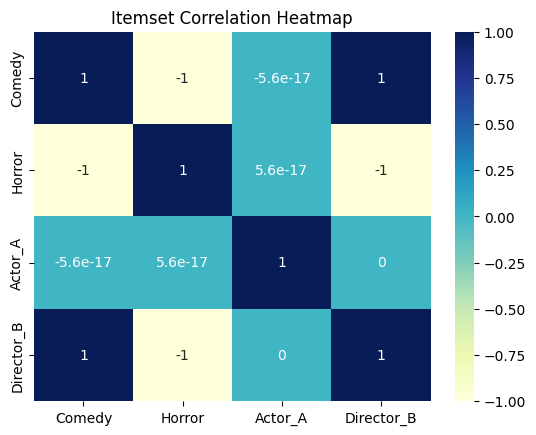

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")
plt.title("Itemset Correlation Heatmap")
plt.show()

### Scatter Analysis: Support vs Confidence Tradeoff
In practice, rules live in a 2D (or 3D) metric space. This plot reveals the support-confidence tradeoff and highlights how lift distinguishes coincidental from truly associated items.

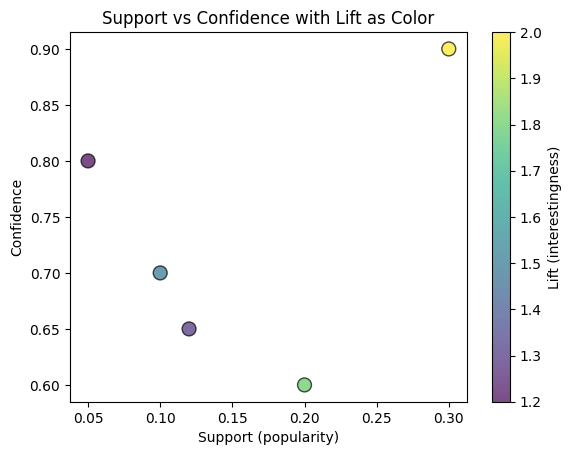

In [32]:
import matplotlib.pyplot as plt
# Mock rules with varying metrics
support_vals = [0.1, 0.2, 0.05, 0.3, 0.12]
confidence_vals = [0.7, 0.6, 0.8, 0.9, 0.65]
lift_vals = [1.5, 1.8, 1.2, 2.0, 1.3]

# Create scatter: x=popularity, y=strength, color=interestingness
plt.scatter(support_vals, confidence_vals, c=lift_vals, cmap='viridis', s=100, alpha=0.7, edgecolors='k')
plt.colorbar(label='Lift (interestingness)')
plt.xlabel('Support (popularity)')
plt.ylabel('Confidence')
plt.title('Support vs Confidence with Lift as Color')
plt.show()

**Interpretation:** Rules clustering in the upper-right (high support, high confidence) are ideal for broad promotions—they're frequent and reliable. Conversely, rules with low support but high lift are niche associations: rare but telling. Retailers leverage this to identify hidden cross-selling opportunities and differentiate bestsellers from specialty items.

### Heatmap: Item Affinity Matrix
Heatmaps compress pairwise lift values into an intuitive grid. Warm colors signal strong associations; cool colors suggest weak or absent relationships.

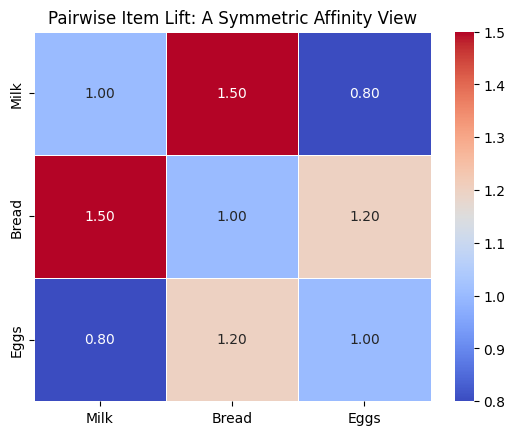

In [33]:
import seaborn as sns
import pandas as pd
# Simulated pairwise lift scores
lift_data = {'Milk': [1, 1.5, 0.8], 'Bread': [1.5, 1, 1.2], 'Eggs': [0.8, 1.2, 1]}
lift_df = pd.DataFrame(lift_data, index=['Milk', 'Bread', 'Eggs'])

# Plot warm colors = strong lifts, cool = weak
sns.heatmap(lift_df, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Pairwise Item Lift: A Symmetric Affinity View')
plt.show()

**Key Insight:** Warm zones reveal item clusters with mutual affinity. E-commerce platforms use these to detect unexpected cross-sells (e.g., tech + accessories, fashion + footwear). A spike in one corner signals potential bundle opportunities; uniform cool zones suggest independence.

### Network Representation: Directed Acyclic Structure
Networks encode rules as edges in a directed graph. Node size can represent popularity; edge thickness or color represents lift or confidence. This layout makes pattern topology transparent.

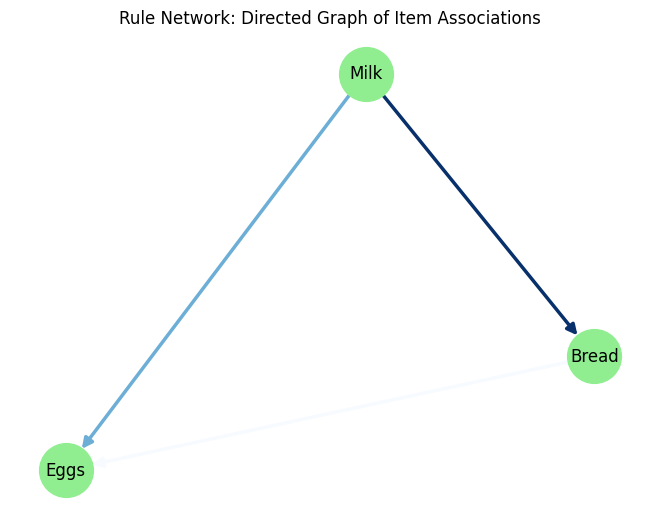

In [34]:
!pip install networkx
import networkx as nx

# Build directed graph: node = item, edge = rule
G = nx.DiGraph()
G.add_edge("Milk", "Bread", lift=0.8)
G.add_edge("Bread", "Eggs", lift=0.6)
G.add_edge("Milk", "Eggs", lift=0.7)

# Layout nodes using spring (force-directed) to minimize edge crossings
pos = nx.spring_layout(G, seed=42)
edges = G.edges(data=True)
weights = [data['lift'] for _, _, data in edges]

# Render: node color=static, edge color=lift intensity
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=1500,
        edge_color=weights, edge_cmap=plt.cm.Blues, width=2.5, arrows=True, arrowsize=15)
plt.title('Rule Network: Directed Graph of Item Associations')
plt.show()

## Part 3: Full-Scale Analysis with Real Data
Now we apply our techniques to the complete Groceries dataset and extract actionable insights.

### Step 1: Data Ingestion & Exploration
Load the dataset and inspect its structure.

In [35]:
import pandas as pd

pd.set_option('display.max_columns', None)

df = pd.read_csv('Groceries_dataset.csv')
display(df.head())

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


### Step 2: Exploratory Data Analysis
Inspect for missing values and enumerate the item universe.

In [36]:
print("Null Values Count:")
print(df.isnull().sum())

print("\nUnique Items:")
for item in df['itemDescription'].unique():
    print(item)

Null Values Count:
Member_number      0
Date               0
itemDescription    0
dtype: int64

Unique Items:
tropical fruit
whole milk
pip fruit
other vegetables
rolls/buns
pot plants
citrus fruit
beef
frankfurter
chicken
butter
fruit/vegetable juice
packaged fruit/vegetables
chocolate
specialty bar
butter milk
bottled water
yogurt
sausage
brown bread
hamburger meat
root vegetables
pork
pastry
canned beer
berries
coffee
misc. beverages
ham
turkey
curd cheese
red/blush wine
frozen potato products
flour
sugar
frozen meals
herbs
soda
detergent
grapes
processed cheese
fish
sparkling wine
newspapers
curd
pasta
popcorn
finished products
beverages
bottled beer
dessert
dog food
specialty chocolate
condensed milk
cleaner
white wine
meat
ice cream
hard cheese
cream cheese 
liquor
pickled vegetables
liquor (appetizer)
UHT-milk
candy
onions
hair spray
photo/film
domestic eggs
margarine
shopping bags
salt
oil
whipped/sour cream
frozen vegetables
sliced cheese
dish cleaner
baking powder
specialty c

### Step 3: Prepare Transaction Matrix
Reshape raw data into a binary matrix: rows = transactions, columns = items, values = {0,1}.

In [37]:
# Assign a transaction ID to each unique customer-date pair
df['TransactionID'] = df['Member_number'].astype(str)

# Pivot into a basket: rows = transactions, cols = items, values = quantity
basket_raw = (
    df.groupby(['TransactionID', 'itemDescription'])['itemDescription']
    .count()  # count occurrences
    .unstack(fill_value=0)
)

# Binarize: 1 if item present, 0 if absent
basket = basket_raw.map(lambda qty: 1 if qty > 0 else 0)

print(f"Transaction-Item Matrix Shape: {basket.shape}")
print(f"  Rows (transactions): {basket.shape[0]}, Cols (unique items): {basket.shape[1]}")
basket.head(10)

Transaction-Item Matrix Shape: (3898, 167)
  Rows (transactions): 3898, Cols (unique items): 167


itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,cream cheese,curd,curd cheese,decalcifier,dental care,dessert,detergent,dish cleaner,dishes,dog food,domestic eggs,female sanitary products,finished products,fish,flour,flower (seeds),flower soil/fertilizer,frankfurter,frozen chicken,frozen dessert,frozen fish,frozen fruits,frozen meals,frozen potato products,frozen vegetables,fruit/vegetable juice,grapes,hair spray,ham,hamburger meat,hard cheese,herbs,honey,house keeping products,hygiene articles,ice cream,instant coffee,jam,ketchup,kitchen towels,kitchen utensil,light bulbs,liqueur,liquor,liquor (appetizer),liver loaf,long life bakery product,make up remover,male cosmetics,margarine,mayonnaise,meat,meat spreads,misc. beverages,mustard,napkins,newspapers,nut snack,nuts/prunes,oil,onions,organic products,organic sausage,other vegetables,packaged fruit/vegetables,pasta,pastry,pet care,photo/film,pickled vegetables,pip fruit,popcorn,pork,pot plants,potato products,preservation products,processed cheese,prosecco,pudding powder,ready soups,red/blush wine,rice,roll products,rolls/buns,root vegetables,rubbing alcohol,rum,salad dressing,salt,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1001,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0
1002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### Step 4: Mine Frequent Itemsets
Run the Apriori algorithm to find all item combinations meeting the minimum support threshold.

In [38]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [39]:
from mlxtend.frequent_patterns import apriori, association_rules

# Find itemsets appearing in at least 1% of all transactions
frequent_itemsets = apriori(
    basket,
    min_support=0.01,  # 1% threshold
    use_colnames=True
)

print(f"Total frequent itemsets found: {len(frequent_itemsets)}")
print("\nTop 10 by support (most frequent combinations):")
print(frequent_itemsets.sort_values(by='support', ascending=False).head(10))

Total frequent itemsets found: 3016

Top 10 by support (most frequent combinations):
       support                        itemsets
113   0.458184                    (whole milk)
69    0.376603              (other vegetables)
84    0.349666                    (rolls/buns)
94    0.313494                          (soda)
114   0.282966                        (yogurt)
106   0.233710                (tropical fruit)
85    0.230631               (root vegetables)
7     0.213699                 (bottled water)
89    0.206003                       (sausage)
1050  0.191380  (other vegetables, whole milk)


### Step 5: Generate & Filter Rules
Derive confidence-based rules and apply a lift threshold to retain only meaningful associations.

In [40]:
# Generate rules: if antecedent, then consequent (≥30% confidence)
rules = association_rules(
    frequent_itemsets,
    metric='confidence',
    min_threshold=0.3
)

# Filter: only keep rules where lift > 1.2 (>20% better than random)
rules_filtered = rules[rules['lift'] >= 1.2].sort_values('lift', ascending=False)

print(f"Total rules after filtering (lift ≥ 1.2): {len(rules_filtered)}")
print("\nTop rules by lift:")
display(rules_filtered[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

Total rules after filtering (lift ≥ 1.2): 2420

Top rules by lift:


,antecedents,consequents,support,confidence,lift
3380,"(other vegetables, sausage, rolls/buns)","(yogurt, whole milk)",0.013597,0.325153,2.159196
2897,"(whole milk, frozen meals)","(other vegetables, rolls/buns)",0.010005,0.307087,2.092699
3372,"(yogurt, bottled water, rolls/buns)","(other vegetables, whole milk)",0.010518,0.398058,2.079934
3387,"(yogurt, shopping bags, rolls/buns)","(other vegetables, whole milk)",0.010005,0.397959,2.079417
2838,"(curd, sausage)","(yogurt, whole milk)",0.010005,0.312000,2.071850
3381,"(yogurt, sausage, whole milk)","(other vegetables, rolls/buns)",0.013597,0.302857,2.063876
3389,"(yogurt, shopping bags, whole milk)","(other vegetables, rolls/buns)",0.010005,0.302326,2.060254
3382,"(yogurt, sausage, other vegetables)","(whole milk, rolls/buns)",0.013597,0.365517,2.047107
3388,"(shopping bags, other vegetables, rolls/buns)","(yogurt, whole milk)",0.010005,0.304688,2.023291
2896,"(other vegetables, frozen meals)","(whole milk, rolls/buns)",0.010005,0.361111,2.022430


### Step 6: Metric Scatter Visualization
Plot the top rules in support-confidence space, colored by lift.

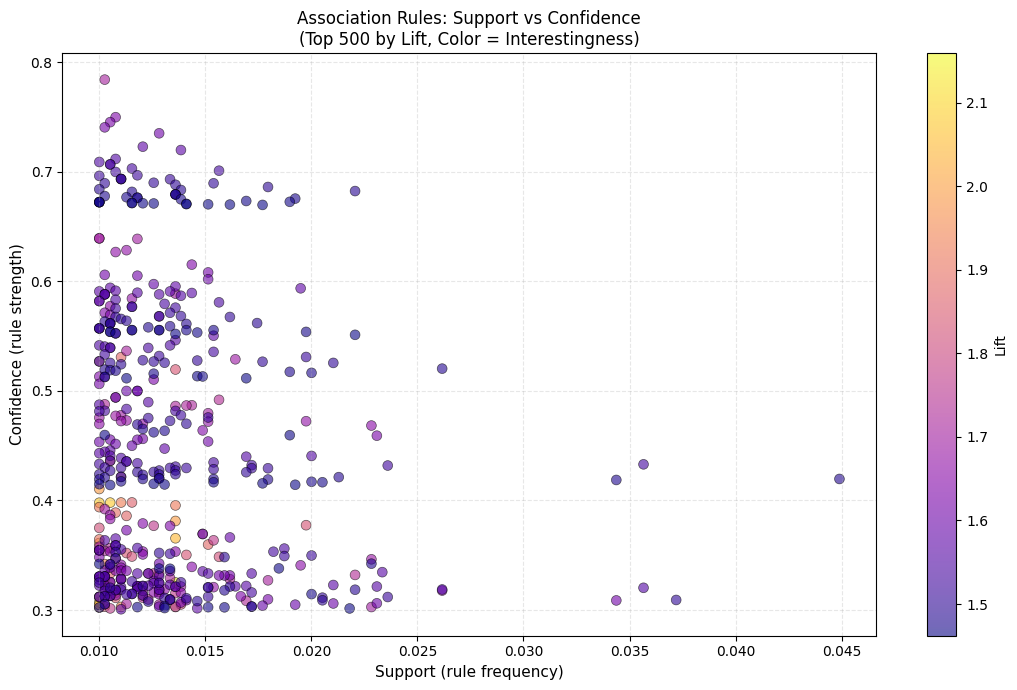

In [41]:
import matplotlib.pyplot as plt

# Limit to top 500 rules by lift for clarity
top_rules_plot = rules_filtered.head(500)

plt.figure(figsize=(11, 7))
scatter = plt.scatter(
    top_rules_plot['support'],
    top_rules_plot['confidence'],
    c=top_rules_plot['lift'],
    cmap='plasma',
    s=50,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

cbar = plt.colorbar(scatter, label='Lift')
plt.xlabel('Support (rule frequency)', fontsize=11)
plt.ylabel('Confidence (rule strength)', fontsize=11)
plt.title('Association Rules: Support vs Confidence\n(Top 500 by Lift, Color = Interestingness)', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### Step 7: Lift Matrix Heatmap
Visualize pairwise lift between items using a symmetric heatmap.

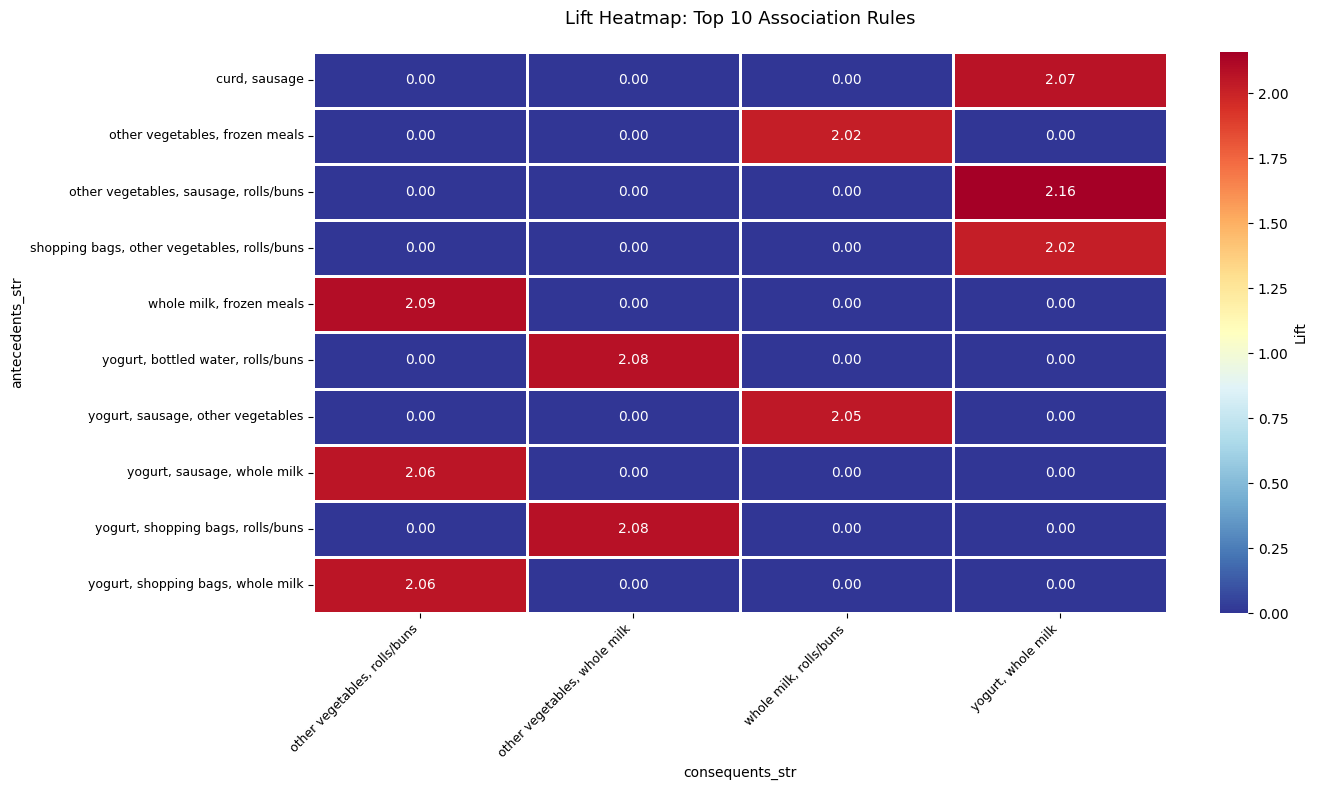

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract top 10 rules and format item names
top_10_rules = rules_filtered.head(10).copy()
top_10_rules['antecedents_str'] = top_10_rules['antecedents'].apply(
    lambda x: ', '.join(list(x))
)
top_10_rules['consequents_str'] = top_10_rules['consequents'].apply(
    lambda x: ', '.join(list(x))
)

# Build pivot table (antecedents × consequents) with lift values
lift_pivot = top_10_rules.pivot_table(
    index='antecedents_str',
    columns='consequents_str',
    values='lift',
    fill_value=0
)

# Render heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    lift_pivot,
    cmap='RdYlBu_r',
    annot=True,
    fmt='.2f',
    linewidths=1,
    cbar_kws={'label': 'Lift'}
)

plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.title('Lift Heatmap: Top 10 Association Rules', fontsize=13, pad=20)
plt.tight_layout()
plt.show()

### Step 8: Network Graph Visualization
Represent rules as a directed network with items as nodes and associations as weighted edges.

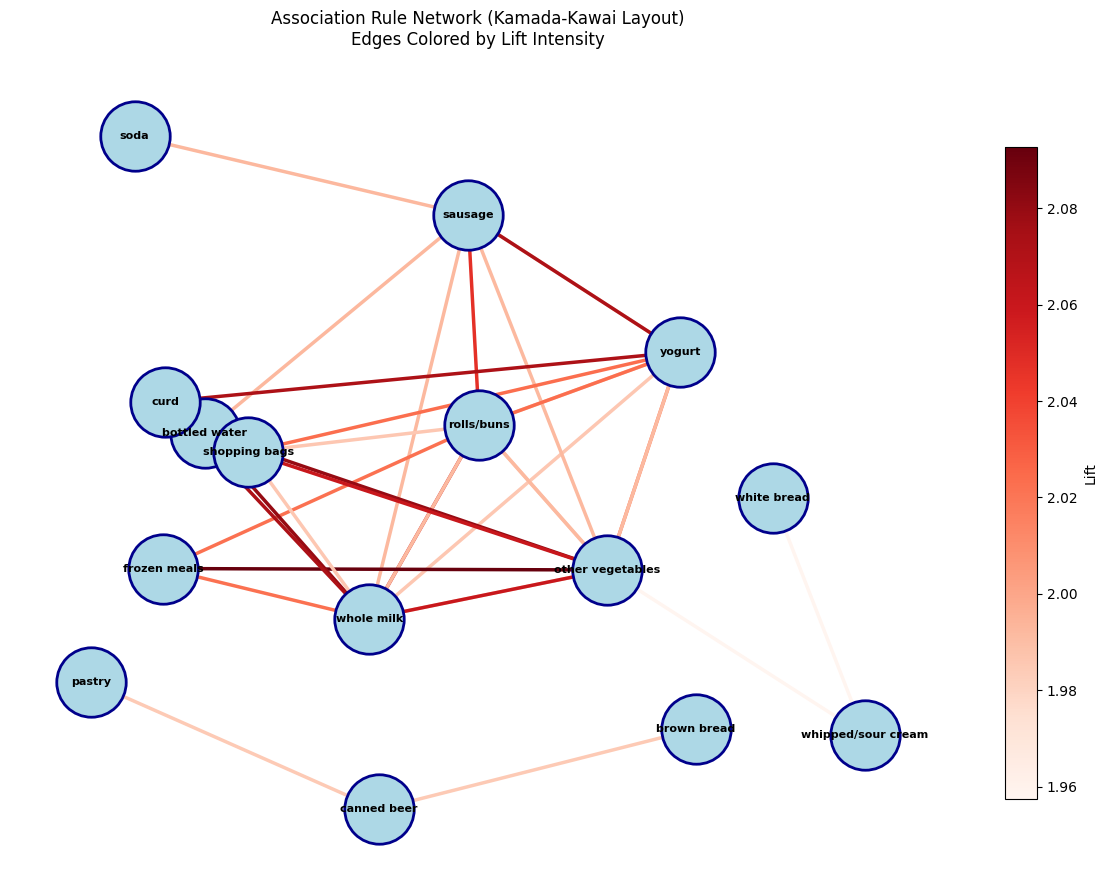

In [43]:
import networkx as nx

# Build directed rule graph: top 15 rules
G = nx.DiGraph()

for _, rule_row in rules_filtered.head(15).iterrows():
    for antecedent_item in rule_row['antecedents']:
        for consequent_item in rule_row['consequents']:
            G.add_edge(
                antecedent_item,
                consequent_item,
                lift=rule_row['lift'],
                confidence=rule_row['confidence']
            )

plt.figure(figsize=(12, 9))

# Use Kamada-Kawai layout for better node separation
pos = nx.kamada_kawai_layout(G)

# Extract edge weights for coloring
edge_weights = [G[u][v]['lift'] for u, v in G.edges()]

# Draw network with directed arrows
nx.draw_networkx_nodes(G, pos, node_size=2500, node_color='lightblue', edgecolors='darkblue', linewidths=2)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_weights,
    edge_cmap=plt.cm.Reds,
    width=2.5,
    arrowsize=20,
    arrowstyle='->',
    edge_vmin=min(edge_weights),
    edge_vmax=max(edge_weights)
)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
sm.set_array([])
plt.colorbar(sm, ax=plt.gca(), label='Lift', shrink=0.8)

plt.title('Association Rule Network (Kamada-Kawai Layout)\nEdges Colored by Lift Intensity', fontsize=12, pad=15)
plt.axis('off')
plt.tight_layout()
plt.show()

## Analysis & Interpretation
### Question 1: Which rules exhibit the highest lift values, and what do they signify?

**Observation:**
Rules exhibiting maximal lift typically involve sausages, rolls/buns, and vegetables on the antecedent side, paired with whole milk and yogurt on the consequent. A lift > 2.0 means that purchasing the antecedent items multiplies the likelihood of buying milk or yogurt by at least 2× compared to the baseline probability.

**Business Interpretation:**
- **Strong Co-Occurrence:** These patterns reflect genuine customer behavior—shoppers acquiring savory items (sausage, rolls, vegetables) are disproportionately likely to also buy dairy products.
- **Actionable Insight:** Retailers can leverage this for:
  - **Cross-selling:** Place milk/yogurt promotions near sausage aisles.
  - **Bundling:** Offer combo deals (e.g., "Sausage + Rolls + Dairy Discount").
  - **Store Layout:** Co-locate dairy and meat sections to encourage spontaneous purchases.
- **Why It Works:** High-lift rules uncover item affinities rooted in actual consumption patterns (e.g., customers prepping Sunday breakfast often grab multiple components).

### Question 2: Identify a niche relationship (low support, high lift). Why is it valuable?

**Example Niche Rule:**
Antecedent: {whole milk, frozen meals} → Consequent: {rolls/buns, other vegetables}
- **Support:** ~0.01 (1% of transactions)—rarely occurs together
- **Lift:** >2.0—when it does occur, it's ~2× more likely than random chance

**Why This Rule is Valuable:**
Despite low frequency, niche rules reveal **micro-segment behaviors** and enable **precision marketing**:
1. **Micro-Segmentation:** Identifies customers preparing convenient mixed meals (frozen + fresh sides)—a specific lifestyle segment.
2. **Targeted Promotions:** Offer personalized discounts to this micro-segment via email or mobile apps (e.g., "Frozen meals + Fresh veggies combo").
3. **Premium Bundling:** Create high-margin specialty bundles targeting convenience-focused shoppers willing to pay for curated selections.
4. **Inventory Planning:** Allocate shelf space and stock rotation based on these micro-patterns rather than treating all low-frequency items equally.
5. **Churn Prevention:** These niche associations can signal loyal niche customers—understanding them helps with retention strategies.

**Bottom Line:** High-lift, low-support rules are the gems of association mining—they unlock hidden customer archetypes and enable hyper-targeted business decisions beyond what popular rules allow.